# Проект: Определение возраста покупателей

**Описание проекта**

Сетевой супермаркет «Хлеб-Соль» (название вымышленное) внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В моём распоряжении набор фотографий людей с указанием возраста.

Изучим имеющиеся данные и попытаемся построить модель компьютерного зрения для решения поставленной задачи.

Задачи:
- Провести исследовательский анализ набора фотографий.
- Подготовить данные к обучению.
- Обучить нейронную сеть и рассчитать её качество.
- Значение метрики **MAE** не должно быть выше значения: 8.

*Примечание:* Обучение нейронной сети выполнялось на GPU-процессорах. В тетради продемонстрирован код сборки нейронной сети, процесс и результаты обучения.

**Описание данных**

Данные взяты с сайта [ChaLearn Looking at People](http://chalearnlap.cvc.uab.es/dataset/26/description/).
В моём распоряжении папка с изображениями. И csv-файл: `labels.csv`, с двумя колонками: `file_name` и `real_age`. 

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Анализ-обученной-модели" data-toc-modified-id="Анализ-обученной-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ обученной модели</a></span></li><li><span><a href="#Чек-лист" data-toc-modified-id="Чек-лист-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист</a></span></li></ul></div>

# Исследовательский анализ данных

## Исследовательский анализ данных

Импортируем необходимые библиотеки:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Загрузим данные и посмотрим на них:

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

train_datagen = ImageDataGenerator(rescale=1./255.)

train_gen_flow = train_datagen.flow_from_dataframe(
    dataframe=labels, directory='/datasets/faces/final_files/',
    x_col='file_name', y_col='real_age',
    target_size=(224, 224), batch_size=32,
    class_mode='raw', seed=555)

Found 7591 validated image filenames.


Получилась довольно большая выборка из 7591 изображения. К тому-же если мы будем применять аугментацию, то выборка станет ещё больше, что позволит модели лучше обучиться.

Посмотрим на таблицу с целевыми признаками:

In [3]:
labels

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


In [4]:
labels.sample(10, random_state=555)

,file_name,real_age
3596,003596.jpg,33
6458,006462.jpg,33
2653,002653.jpg,32
1050,001050.jpg,35
4809,004809.jpg,21
3296,003296.jpg,22
1381,001381.jpg,20
1809,001809.jpg,24
1762,001762.jpg,42
6082,006085.jpg,81


In [5]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Данные выглядят корректно, типы данных соответствуют содержанию, пропусков не наблюдается.

Посмотрим на распределение возрастов:

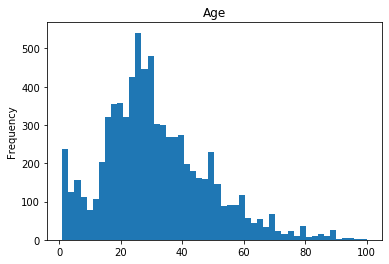

In [6]:
labels.real_age.plot(kind='hist', bins=50, title='Age')
plt.show()

Распределение выглядит нормальным, выбросов не наблюдается. Имеются пики на круглых числах. Возможно это связано с тем, что у некоторых изображений указывался примерный возраст, то есть округлялся до десятков. Ещё на возрасте 60+ довольно мало примеров, вероятно на этих возрастах модель плохо обучится и будут ошибки на предсказаниях пожилых людей. И имеется пик на возрасте до 10-и лет. Видимо присутствует довольно много фотографий маленьких детей. Это не плохо, но для магазина это не особо нужно. По сути, если эту категорию исключить из обучения, то на результат это не должно негативно повлиять.

Теперь посмотрим на фотографии. Выведем 16 изображений:

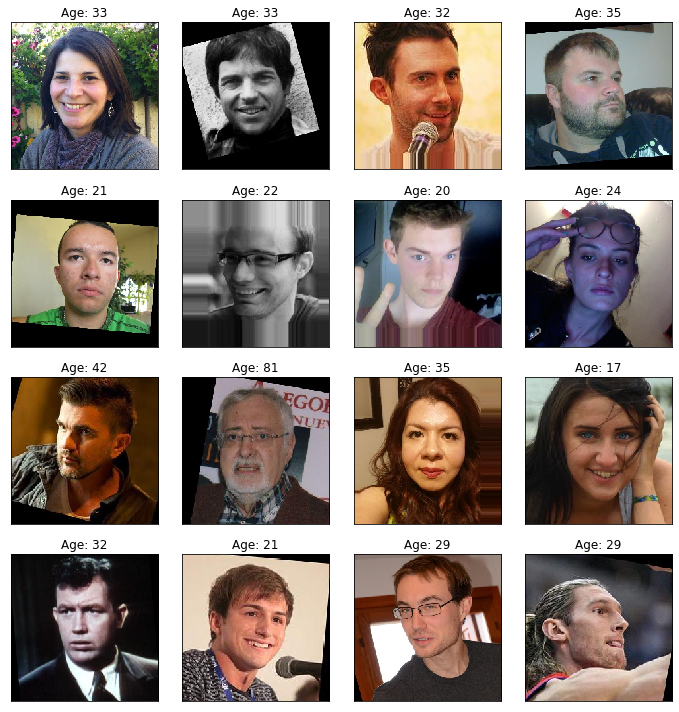

In [7]:
features, target = next(train_gen_flow)
fig = plt.figure(figsize=(10, 10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title('Age: {}'.format(target[i]))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Фотографии выглядят хорошо, без явных искажений в области лица. Чтобы улучшить обучение, думаю будет полезным, применить горизонтальный разворот изображений в обучающей выборке. Так-же можно попробовать небольшие повороты на 10-15 градусов и поиграться немного с яркостью и масштабом, так как есть фото с небольшим поворотом лица и немного темноватые изображения.

Можно переходить к обучению модели.

## Обучение модели

```python

# Произведём необходимые импорты:

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
import pandas as pd

#---------------------------------------------------------------------------
# Теперь создадим функции для загрузки выборок.
# Сначала создадим обучающую выборку. В ней применим горизонтальный поворот:

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255.,
        horizontal_flip=True)
    
    train_data = train_datagen.flow_from_dataframe(
        dataframe=labels, directory=path + 'final_files/',
        x_col='file_name', y_col='real_age',
        target_size=(224, 224), batch_size=16,
        class_mode='raw', subset='training', seed=555)
    
    return train_data

# Далее создадим тестовую выборку:

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255.)
    
    test_data = test_datagen.flow_from_dataframe(
        dataframe=labels, directory=path + 'final_files/',
        x_col='file_name', y_col='real_age',
        target_size=(224, 224), batch_size=16,
        class_mode='raw', subset='validation', seed=555)
    
    return test_data

#---------------------------------------------------------------------------
# Теперь создадим функцию в которой сконструируем модель.
# Будем использовать ResNet50 в сочетании с GlobalAveragePooling
# и выходным слоем в 1 нейрон с функцией активации ReLu,
# так как значения ниже нуля нам не нужны.
# Accuracy будем измерять метрикой MAE:

def create_model(input_shape):
    model = Sequential()
    optimizer = Adam(lr=0.0001)
    
    beckbone = ResNet50(input_shape=input_shape, weights='imagenet',
                    include_top=False)
    
    model.add(beckbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer,
                  loss='mse', metrics=['mae'])
    return model

#---------------------------------------------------------------------------
# И наконец создадим функцию обучения модели.
# Обучим модель на 10-и эпохах:

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    
    model.fit(train_data,
          validation_data=test_data,
          epochs=epochs, 
          steps_per_epoch=steps_per_epoch,
          validation_steps=validation_steps, 
          verbose=2,
          shuffle=True)
    return model
```

Результат обучения:

```
Using TensorFlow backend.

Found 5694 validated image filenames.

Found 1897 validated image filenames.

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 356 steps, validate for 119 steps

Epoch 1/10

356/356 - 110s - loss: 212.4956 - mae: 10.4861 - val_loss: 832.5501 - val_mae: 23.9134

Epoch 2/10

356/356 - 38s - loss: 83.5534 - mae: 6.9648 - val_loss: 185.1687 - val_mae: 10.0012

Epoch 3/10

356/356 - 38s - loss: 57.2720 - mae: 5.7814 - val_loss: 82.6802 - val_mae: 6.8144

Epoch 4/10

356/356 - 37s - loss: 43.3859 - mae: 5.0252 - val_loss: 72.1128 - val_mae: 6.2703

Epoch 5/10

356/356 - 38s - loss: 32.3188 - mae: 4.3842 - val_loss: 74.2402 - val_mae: 6.4233

Epoch 6/10

356/356 - 38s - loss: 26.2875 - mae: 3.9103 - val_loss: 94.6945 - val_mae: 7.1136

Epoch 7/10

356/356 - 37s - loss: 21.2360 - mae: 3.5485 - val_loss: 84.7967 - val_mae: 6.7929

Epoch 8/10

356/356 - 37s - loss: 17.6969 - mae: 3.1831 - val_loss: 71.2029 - val_mae: 6.4129

Epoch 9/10

356/356 - 37s - loss: 14.4412 - mae: 2.9049 - val_loss: 61.7293 - val_mae: 5.7861

Epoch 10/10

356/356 - 38s - loss: 13.1531 - mae: 2.7618 - val_loss: 73.7826 - val_mae: 6.3323


119/119 - 9s - loss: 73.7826 - mae: 6.3323

Test MAE: 6.3323

```

## Анализ обученной модели

Результат обучения модели на 10-и эпохах:
- МАЕ на обучающей выборке: 2.76;
- МАЕ на тестовой выборке: 6.33.

Целевой метрики удалось достичь несмотря на то, что модель явно переобучилась.

В целом, результат хороший. Но единственное, в чём может возникнуть проблема при реализации модели в магазине, это то, что могут быть ошибки с определением возраста у подростков. То есть, например 16-и летнего подростка покупающего алкоголь, модель может пропустить как более взрослого. В таком случае кассир может не спросить у него документы и это может вызвать проблемы.